In [41]:
## Approach 1

from mealpy import FloatVar, BinaryVar, SCA, GWO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def combined_imputation_then_selection(data, epoch_sca=50, pop_sca=10, epoch_gwo=30, pop_gwo=20):
    features = data[:, :-1]
    target = data[:, -1]
    nan_indices = np.argwhere(np.isnan(features))

    # Scale only complete rows for bounds
    complete_rows = ~np.isnan(features).any(axis=1)
    scaler = StandardScaler()
    scaler.fit(features[complete_rows])
    scaled_bounds = scaler.transform(features[complete_rows])

    # Compute lower and upper bounds for each feature (for imputation)
    lb_feat = np.nanmin(scaled_bounds, axis=0)
    ub_feat = np.nanmax(scaled_bounds, axis=0)
    lb = [lb_feat[c] for r, c in nan_indices]
    ub = [ub_feat[c] for r, c in nan_indices]

    def sca_fitness(solution):
        temp_features = features.copy()
        for i, (r, c) in enumerate(nan_indices):
            temp_features[r, c] = solution[i]

        try:
            scaled = scaler.transform(temp_features)
        except:
            return 1.0  # Invalid data fallback

        X_train, X_test, y_train, y_test = train_test_split(
            scaled, target, test_size=0.2, random_state=42)

        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)

        return 1 - acc  # Minimize 1 - accuracy


    sca_problem = {
        "bounds": FloatVar(lb=lb, ub=ub, name="impute_vals"),
        "minmax": "min",
        "obj_func": sca_fitness
    }

    sca_model = SCA.DevSCA(epoch=epoch_sca, pop_size=pop_sca)
    sca_result = sca_model.solve(sca_problem)

    # Impute missing values with SCA solution
    final_features = features.copy()
    for i, (r, c) in enumerate(nan_indices):
        final_features[r, c] = sca_result.solution[i]

    final_features = scaler.transform(final_features)

    # === GWO for feature selection (on full imputed and scaled dataset) ===
    def gwo_fitness(mask):
        mask = np.round(mask).astype(int)
        if np.sum(mask) == 0:
            idx = np.random.randint(0, len(mask))
            mask[idx] = 1  # Force at least one feature

        selected = final_features[:, mask == 1]
        X_train, X_test, y_train, y_test = train_test_split(
            selected, target, test_size=0.2, random_state=42)

        model = KNeighborsClassifier(n_neighbors=5)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        return 1 - acc  # Minimize loss

    gwo_problem = {
        "bounds": BinaryVar(n_vars=features.shape[1], name="feature_mask"),
        "minmax": "min",
        "obj_func": gwo_fitness
    }

    gwo_model = GWO.OriginalGWO(epoch=epoch_gwo, pop_size=pop_gwo)
    gwo_result = gwo_model.solve(gwo_problem)

    best_mask = np.round(gwo_result.solution).astype(bool)
    final_accuracy = 1 - gwo_result.target.fitness

    print(f"✅ Meilleure sélection d'attributs : {best_mask}")
    print(f"🎯 Accuracy finale : {final_accuracy:.4f}")
    return best_mask, final_accuracy

# === Utilisation ===
df = pd.read_csv("water_potability.csv")
data = df.to_numpy()
selected_features, acc = combined_imputation_then_selection(
    data, epoch_sca=100, pop_sca=5, epoch_gwo=20, pop_gwo=10)


2025/05/06 07:52:21 PM, INFO, mealpy.math_based.SCA.DevSCA: Solving single objective optimization problem.
2025/05/06 07:52:22 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 1, Current best: 0.36585365853658536, Global best: 0.36585365853658536, Runtime: 0.15298 seconds
2025/05/06 07:52:22 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 2, Current best: 0.36585365853658536, Global best: 0.36585365853658536, Runtime: 0.15095 seconds
2025/05/06 07:52:22 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 3, Current best: 0.36585365853658536, Global best: 0.36585365853658536, Runtime: 0.15160 seconds
2025/05/06 07:52:22 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 4, Current best: 0.364329268292683, Global best: 0.364329268292683, Runtime: 0.14824 seconds
2025/05/06 07:52:22 PM, INFO, mealpy.math_based.SCA.DevSCA: >>>Problem: P, Epoch: 5, Current best: 0.364329268292683, Global best: 0.364329268292683, Runtime: 0.15086 seconds
2025/0

✅ Meilleure sélection d'attributs : [ True  True False  True  True False False False False]
🎯 Accuracy finale : 0.6845


In [32]:
# Approach 2
from mealpy import FloatVar, BinaryVar, SCA, GWO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def combined_imputation_selection(data, epoch_sca=50, pop_sca=10, epoch_gwo=10, pop_gwo=5):
    features = data[:, :-1]
    target = data[:, -1]
    nan_indices = np.argwhere(np.isnan(features))

    complete_rows = ~np.isnan(features).any(axis=1)
    scaler = StandardScaler()
    scaler.fit(features[complete_rows])
    scaled_bounds = scaler.transform(features[complete_rows])
    
    # min and max for each column
    lb_feat = np.nanmin(scaled_bounds, axis=0)
    ub_feat = np.nanmax(scaled_bounds, axis=0)

    # bounds for each missing value
    lb = [lb_feat[c] for r, c in nan_indices]
    ub = [ub_feat[c] for r, c in nan_indices]

    def sca_fitness(solution):
        temp_features = features.copy()
        for i, (r, c) in enumerate(nan_indices):
            temp_features[r, c] = solution[i]

        try:
            scaled = scaler.transform(temp_features)
        except:
            return 1.0  # invalid data fallback

        def gwo_fitness(mask):
            mask = np.round(mask).astype(int)

            # If no feature is selected, randomly select one to avoid crash
            if np.sum(mask) == 0:
                idx = np.random.randint(0, len(mask))
                mask[idx] = 1
            
            selected = scaled[:, mask == 1]
            X_train, X_test, y_train, y_test = train_test_split(
                selected, target, test_size=0.2, random_state=42)
              
            if (X_train.shape[1] == 0): 
              return 1.0

            model = KNeighborsClassifier(n_neighbors=5)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            return 1 - acc  # minimize

        gwo_problem = {
            "bounds": BinaryVar(n_vars=features.shape[1], name="feature_mask"),
            "minmax": "min",
            "obj_func": gwo_fitness
        }

        gwo_model = GWO.OriginalGWO(epoch=epoch_gwo, pop_size=pop_gwo)
        gwo_result = gwo_model.solve(gwo_problem)
        return gwo_result.target.fitness  # 1 - acc

    sca_problem = {
        "bounds": FloatVar(lb=lb, ub=ub, name="impute_vals"),
        "minmax": "min",
        "obj_func": sca_fitness
    }

    sca_model = SCA.DevSCA(epoch=epoch_sca, pop_size=pop_sca)
    result = sca_model.solve(sca_problem)

    # Imputation
    final_features = features.copy()
    for i, (r, c) in enumerate(nan_indices):
        final_features[r, c] = result.solution[i]
    final_features = scaler.transform(final_features)
    best_mask = result.solution.astype(bool)
    final_accuracy = 1 - result.target.fitness


    print(f"✅ Meilleure sélection d'attributs : {best_mask}")
    print(f"🎯 Accuracy finale : {final_accuracy:.4f}")
    return best_mask, final_accuracy

# === Utilisation ===
df = pd.read_csv("water_potability.csv")
data = df.to_numpy()
selected_features, acc = combined_imputation_selection(data, epoch_sca=10, pop_sca=10, epoch_gwo=10, pop_gwo=10)


2025/05/06 06:34:30 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: Solving single objective optimization problem.
2025/05/06 06:34:31 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 0.3628048780487805, Global best: 0.3628048780487805, Runtime: 0.19927 seconds
2025/05/06 06:34:31 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 0.3628048780487805, Global best: 0.3628048780487805, Runtime: 0.29287 seconds
2025/05/06 06:34:31 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 0.3414634146341463, Global best: 0.3414634146341463, Runtime: 0.27974 seconds
2025/05/06 06:34:31 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 0.3414634146341463, Global best: 0.3414634146341463, Runtime: 0.27686 seconds
2025/05/06 06:34:32 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 0.3414634146341463, Global best: 0.341463414634146

✅ Meilleure sélection d'attributs : [ True  True  True ...  True  True  True]
🎯 Accuracy finale : 0.7226


In [1]:
# Approach 2
from mealpy import FloatVar, BinaryVar, SCA, GWO
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

accuracies = []

def combined_imputation_selection(data, epoch_sca=50, pop_sca=10, epoch_gwo=10, pop_gwo=5):
    features = data[:, :-1]
    target = data[:, -1]
    nan_indices = np.argwhere(np.isnan(features))

    complete_rows = ~np.isnan(features).any(axis=1)
    scaler = StandardScaler()
    scaler.fit(features[complete_rows])
    scaled_bounds = scaler.transform(features[complete_rows])
    
    # min and max for each column
    lb_feat = np.nanmin(scaled_bounds, axis=0)
    ub_feat = np.nanmax(scaled_bounds, axis=0)

    # bounds for each missing value
    lb = [lb_feat[c] for r, c in nan_indices]
    ub = [ub_feat[c] for r, c in nan_indices]

    def sca_fitness(solution):
        temp_features = features.copy()
        for i, (r, c) in enumerate(nan_indices):
            temp_features[r, c] = solution[i]

        try:
            scaled = scaler.transform(temp_features)
        except:
            return 1.0  # invalid data fallback

        def gwo_fitness(mask):
            mask = np.round(mask).astype(int)

            # If no feature is selected, randomly select one to avoid crash
            if np.sum(mask) == 0:
                idx = np.random.randint(0, len(mask))
                mask[idx] = 1
            
            selected = scaled[:, mask == 1]
            X_train, X_test, y_train, y_test = train_test_split(
                selected, target, test_size=0.2, random_state=42)
              
            if (X_train.shape[1] == 0): 
              return 1.0

            model = KNeighborsClassifier(n_neighbors=5)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)

            if(len(accuracies) == 0): accuracies.append(acc)
            else: 
              if(accuracies[-1] < acc): accuracies.append(acc)            
            
            return 1 - acc  # minimize

        gwo_problem = {
            "bounds": BinaryVar(n_vars=features.shape[1], name="feature_mask"),
            "minmax": "min",
            "obj_func": gwo_fitness
        }

        gwo_model = GWO.OriginalGWO(epoch=epoch_gwo, pop_size=pop_gwo)
        gwo_result = gwo_model.solve(gwo_problem)
        return gwo_result.target.fitness  # 1 - acc

    sca_problem = {
        "bounds": FloatVar(lb=lb, ub=ub, name="impute_vals"),
        "minmax": "min",
        "obj_func": sca_fitness
    }

    sca_model = SCA.DevSCA(epoch=epoch_sca, pop_size=pop_sca)
    result = sca_model.solve(sca_problem)

    # Imputation
    final_features = features.copy()
    for i, (r, c) in enumerate(nan_indices):
        final_features[r, c] = result.solution[i]
    final_features = scaler.transform(final_features)
    best_mask = result.solution.astype(bool)
    final_accuracy = 1 - result.target.fitness


    print(f"✅ Meilleure sélection d'attributs : {best_mask}")
    print(f"🎯 Accuracy finale : {final_accuracy:.4f}")
    return best_mask, final_accuracy

# === Utilisation ===
df = pd.read_csv("water_potability.csv")
data = df.to_numpy()
selected_features, acc = combined_imputation_selection(data, epoch_sca=10, pop_sca=10, epoch_gwo=10, pop_gwo=10)


2025/05/16 12:00:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: Solving single objective optimization problem.
2025/05/16 12:00:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 0.31707317073170727, Global best: 0.31707317073170727, Runtime: 0.22129 seconds
2025/05/16 12:00:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 0.31707317073170727, Global best: 0.31707317073170727, Runtime: 0.30695 seconds
2025/05/16 12:00:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 0.31707317073170727, Global best: 0.31707317073170727, Runtime: 0.27511 seconds
2025/05/16 12:00:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 0.31707317073170727, Global best: 0.31707317073170727, Runtime: 0.23450 seconds
2025/05/16 12:00:58 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 0.31707317073170727, Global best: 0.317073

✅ Meilleure sélection d'attributs : [ True  True  True ...  True  True  True]
🎯 Accuracy finale : 0.7210


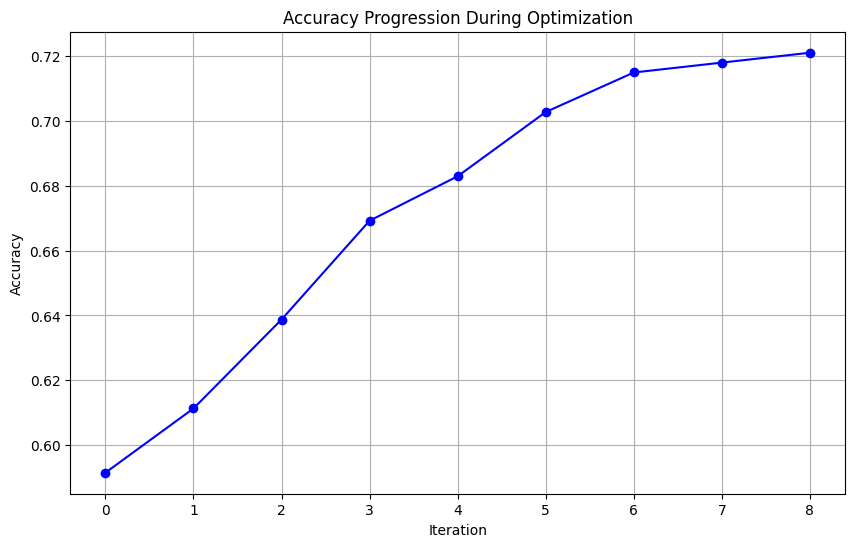

In [2]:
import matplotlib.pyplot as plt

# After running the combined_imputation_selection function
plt.figure(figsize=(10, 6))
plt.plot(accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy Progression During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

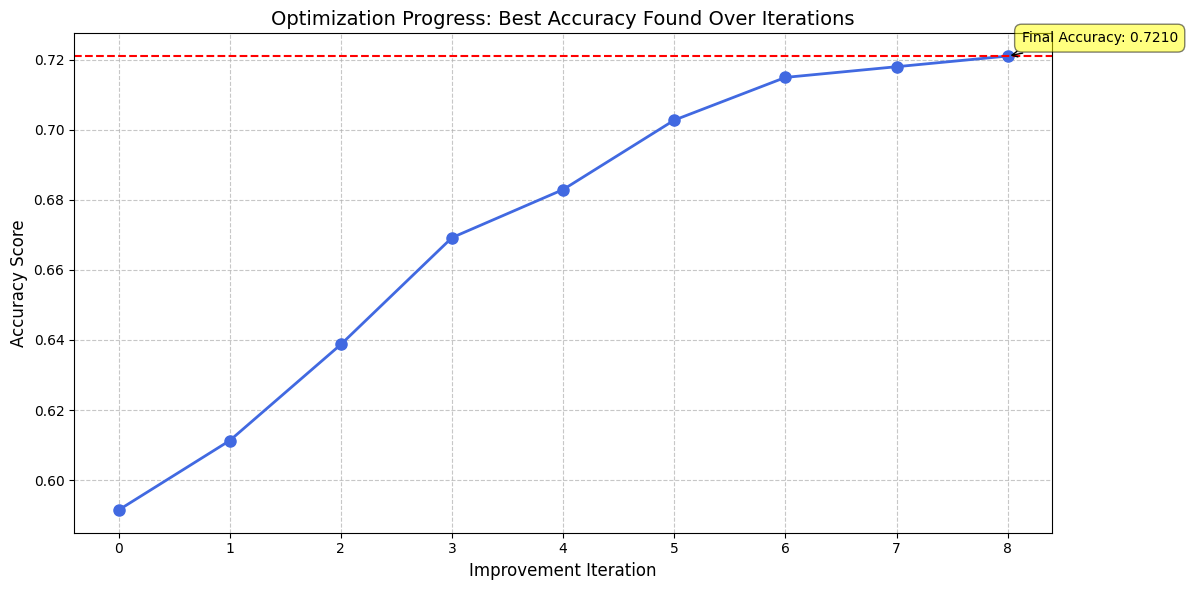

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(accuracies, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8)
plt.title('Optimization Progress: Best Accuracy Found Over Iterations', fontsize=14)
plt.xlabel('Improvement Iteration', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight final accuracy
final_acc = accuracies[-1]
plt.axhline(y=final_acc, color='r', linestyle='--', linewidth=1.5)
plt.annotate(f'Final Accuracy: {final_acc:.4f}', 
             xy=(len(accuracies)-1, final_acc),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->'))

plt.tight_layout()
plt.show()